# Generating abstract art using DCGAN

The goal of this project is to train a DCGAN to generate new works of abstract art. The implementation will be done in PyTorch. 

This project will utilze the model proposed by the 2015 paper "UNSUPERVISED REPRESENTATION LEARNING WITH DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORKS", which advocates the idea of using strided convolution to replace pooling layers.

Dataset used: https://www.kaggle.com/datasets/bryanb/abstract-art-gallery

Checkpoint Dataset I made: https://www.kaggle.com/datasets/therealcyberlord/abstract-art-generation-dcgan-checkpoints

![](https://github.com/therealcyberlord/DCGAN/raw/master/GIFS/gan-visulization.gif)

Sources:
* Arxiv Paper: https://arxiv.org/pdf/1511.06434v2.pdf

* This also take a lot of inspiration from the PyTorch DCGAN Tutorial, check it out <a href="https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html">here</a>



In [1]:
import torch
from torch.nn import functional as F
from torch import nn 
from torch.optim import Adam
from torch.utils.data import DataLoader 
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np 
import random
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm.auto import tqdm


%matplotlib inline 

# set seed for replicable results 
torch.manual_seed(999)
random.seed(10)

In [2]:
image_path = "../input/abstract-art-gallery/"
image_size = (64, 64)
batch_size = 32
latent_size = 100
epoch_restore = 150
checkpoint_path = "../input/abstract-art-generation-dcgan-checkpoints/{}epochs.chkpt".format(epoch_restore)

lr = 0.0002
beta1 = 0.5
epochs = 10

# we read the image data and preprocess it 

dataset = ImageFolder(root=image_path,
                           transform=T.Compose([
                               T.Resize(image_size),
                               T.ToTensor(),
                               # normalize to the range [-1, 1]
                               T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# create a dataloader 
dataloader = DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

In [3]:
device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")

In [4]:
# getting a batch from the dataloader 
batch = next(iter(dataloader))

# Visualize our training images

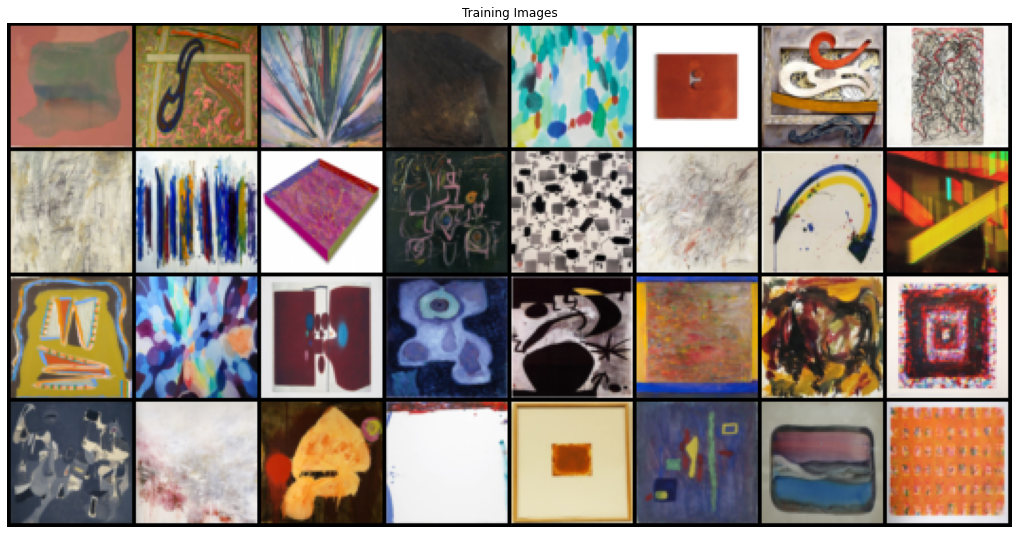

In [5]:
plt.figure(figsize=(18,18))
plt.axis("off")
plt.title("Training Images")

# viewing the training data 
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:batch_size], padding=2, normalize=True).cpu(),(1,2,0)))

# DCGAN Generator Architecture

In [6]:
# custom weights initialization based on the 2015 DCGAN paper 
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

![](https://pytorch.org/tutorials/_images/dcgan_generator.png)

# Generator architecture

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.conv1 = nn.ConvTranspose2d(latent_size, 64*8, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(64*8)
        self.conv2 = nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64*4)
        self.conv3 = nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64*2)
        self.conv4 = nn.ConvTranspose2d(64*2, 64, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = F.relu(self.bn2(self.conv2(x)), inplace=True)
        x = F.relu(self.bn3(self.conv3(x)), inplace=True)
        x = F.relu(self.bn4(self.conv4(x)), inplace=True)
        return torch.tanh(self.conv5(x))

In [8]:
generator = Generator().to(device)
generator.apply(weights_init)

# calculate the trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(generator)
print("Trainable Parameters:", count_parameters(generator))

Generator(
  (conv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)
Trainable Parameters: 3576704


Let's see what we get without training the generator 

In [9]:
untrained_output = generator(torch.randn(1, 100, 1, 1, device=device))
print(untrained_output.shape)

torch.Size([1, 3, 64, 64])


# Discriminator architecture

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(64, 64*2, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64*2)
        self.conv3 = nn.Conv2d(64*2, 64*4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64*4)
        self.conv4 = nn.Conv2d(64*4, 64*8, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64*8)
        self.conv5 = nn.Conv2d(64*8, 1, 4, 1, 0, bias=False)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn1(self.conv2(x)), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv3(x)), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn3(self.conv4(x)), negative_slope=0.2, inplace=True)
        return torch.sigmoid(self.conv5(x))

In [11]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

print(discriminator)
print("Trainable Parameters:", count_parameters(discriminator))

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)
Trainable Parameters: 2765568


Let's see what we get without training the discriminator 

In [12]:
discriminator(untrained_output).view(-1).detach()

tensor([0.8453], device='cuda:0')

In [13]:
# cross binary entropy
criterion = nn.BCELoss()
sampled_noise  = torch.randn(batch_size, latent_size, 1, 1, device=device)

# real is 1 and fake is 0
real_label = 1
fake_label = 0

generator_optim = Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
discriminator_optim = Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

In [14]:
# restore to the latest checkpoint

checkpoint = torch.load(checkpoint_path, map_location=device)
generator.load_state_dict(checkpoint['generator_state_dict'])
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
generator_optim.load_state_dict(checkpoint['generator_optim_state_dict'])
discriminator_optim.load_state_dict(checkpoint['discriminator_optim_state_dict'])

# Training the GAN

In [15]:
generator_loss = []
discriminator_loss = [] 
iters = 0
img_list = []

In [16]:
for epoch in range(epochs):
    for i, data in enumerate(tqdm(dataloader)):
        
        # train the discriminator 
        discriminator.zero_grad()
        real_data = data[0].to(device)
        real_size = real_data.size(0)
        
        # [1, 1, 1, 1...., 1]
        label = torch.ones(real_size, dtype=torch.float32, device=device)
        
        output = discriminator(real_data).view(-1)
        # loss on all-real batch
        error_real_batch = criterion(output, label)
        
        # calculate the derivative wrt parameters
        error_real_batch.backward()
        D_x = output.mean().item()
        
        # generating fake data
        noise = torch.randn(real_size, latent_size, 1, 1, device=device)
        fake_data = generator(noise)
        
        # change the label to [0, 0, 0, 0....., 0]
        label.fill_(fake_label)
        
        # classify all fake batch with discriminator 
        output = discriminator(fake_data.detach()).view(-1)
        error_fake_batch = criterion(output, label)
        error_fake_batch.backward()
        
        # the sum of the discriminator 
        error_discriminator = error_real_batch + error_fake_batch
        discriminator_optim.step()
        
        # train the generator 
        generator.zero_grad()
        # pretend the generated results are real 
        label.fill_(real_label)
        
        output = discriminator(fake_data).view(-1)
        error_generator = criterion(output, label)
        error_generator.backward()
        generator_optim.step()
        
        # print out summary statistics 
        if i % 10 == 0:
            tqdm.write('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, epochs, i, len(dataloader),
                     error_discriminator.item(), error_generator.item()))
            
        discriminator_loss.append(error_discriminator.item())
        generator_loss.append(error_generator.item())
        
         # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fakes = generator(sampled_noise).detach().cpu()
            img_list.append(vutils.make_grid(fakes, padding=2, normalize=True))

        iters += 1
    

  0%|          | 0/90 [00:00<?, ?it/s]

[0/10][0/90]	Loss_D: 0.0795	Loss_G: 5.8660
[0/10][10/90]	Loss_D: 0.0478	Loss_G: 5.8803
[0/10][20/90]	Loss_D: 0.2071	Loss_G: 4.8361
[0/10][30/90]	Loss_D: 0.0494	Loss_G: 6.0720
[0/10][40/90]	Loss_D: 0.0813	Loss_G: 6.8886
[0/10][50/90]	Loss_D: 0.1124	Loss_G: 6.0780
[0/10][60/90]	Loss_D: 0.0480	Loss_G: 6.9192
[0/10][70/90]	Loss_D: 0.0439	Loss_G: 5.5001
[0/10][80/90]	Loss_D: 0.0390	Loss_G: 5.9212


  0%|          | 0/90 [00:00<?, ?it/s]

[1/10][0/90]	Loss_D: 0.1665	Loss_G: 6.4169
[1/10][10/90]	Loss_D: 0.0624	Loss_G: 5.5709
[1/10][20/90]	Loss_D: 0.0951	Loss_G: 5.8067
[1/10][30/90]	Loss_D: 0.0506	Loss_G: 5.1347
[1/10][40/90]	Loss_D: 0.0390	Loss_G: 6.2810
[1/10][50/90]	Loss_D: 0.0710	Loss_G: 5.5254
[1/10][60/90]	Loss_D: 0.0660	Loss_G: 5.1310
[1/10][70/90]	Loss_D: 0.0325	Loss_G: 5.5710
[1/10][80/90]	Loss_D: 0.0913	Loss_G: 5.2468


  0%|          | 0/90 [00:00<?, ?it/s]

[2/10][0/90]	Loss_D: 0.0554	Loss_G: 6.5588
[2/10][10/90]	Loss_D: 0.0980	Loss_G: 5.3525
[2/10][20/90]	Loss_D: 0.2001	Loss_G: 3.1361
[2/10][30/90]	Loss_D: 0.1916	Loss_G: 4.8357
[2/10][40/90]	Loss_D: 0.0714	Loss_G: 5.8303
[2/10][50/90]	Loss_D: 0.2334	Loss_G: 4.7919
[2/10][60/90]	Loss_D: 0.1313	Loss_G: 5.0290
[2/10][70/90]	Loss_D: 0.0580	Loss_G: 5.0020
[2/10][80/90]	Loss_D: 0.0721	Loss_G: 5.2362


  0%|          | 0/90 [00:00<?, ?it/s]

[3/10][0/90]	Loss_D: 0.0467	Loss_G: 6.6430
[3/10][10/90]	Loss_D: 0.4414	Loss_G: 3.3620
[3/10][20/90]	Loss_D: 0.1594	Loss_G: 6.6358
[3/10][30/90]	Loss_D: 0.0580	Loss_G: 5.8766
[3/10][40/90]	Loss_D: 0.2397	Loss_G: 7.1819
[3/10][50/90]	Loss_D: 0.0234	Loss_G: 6.0820
[3/10][60/90]	Loss_D: 0.0768	Loss_G: 5.3426
[3/10][70/90]	Loss_D: 0.0754	Loss_G: 5.1725
[3/10][80/90]	Loss_D: 0.0751	Loss_G: 5.4656


  0%|          | 0/90 [00:00<?, ?it/s]

[4/10][0/90]	Loss_D: 0.0819	Loss_G: 6.1706
[4/10][10/90]	Loss_D: 0.1392	Loss_G: 5.6485
[4/10][20/90]	Loss_D: 0.0156	Loss_G: 5.8129
[4/10][30/90]	Loss_D: 0.1105	Loss_G: 6.8373
[4/10][40/90]	Loss_D: 0.0335	Loss_G: 5.9040
[4/10][50/90]	Loss_D: 0.0202	Loss_G: 6.0440
[4/10][60/90]	Loss_D: 0.0688	Loss_G: 5.5744
[4/10][70/90]	Loss_D: 0.0282	Loss_G: 6.2017
[4/10][80/90]	Loss_D: 0.0350	Loss_G: 5.5296


  0%|          | 0/90 [00:00<?, ?it/s]

[5/10][0/90]	Loss_D: 0.1382	Loss_G: 5.8848
[5/10][10/90]	Loss_D: 0.0211	Loss_G: 5.8977
[5/10][20/90]	Loss_D: 0.1453	Loss_G: 6.1306
[5/10][30/90]	Loss_D: 0.0779	Loss_G: 4.7110
[5/10][40/90]	Loss_D: 0.0785	Loss_G: 5.5287
[5/10][50/90]	Loss_D: 0.1161	Loss_G: 5.1542
[5/10][60/90]	Loss_D: 0.0293	Loss_G: 6.2572
[5/10][70/90]	Loss_D: 0.0320	Loss_G: 5.7493
[5/10][80/90]	Loss_D: 0.0480	Loss_G: 6.7166


  0%|          | 0/90 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4ad2a9ca70>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4ad2a9ca70>

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
Traceback (most recent call last):
      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers

      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
if w.is_alive():    
if w.is_alive():  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive

      File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
assert self._parent_pid == os.getpid(), 'can only 

[6/10][0/90]	Loss_D: 0.0585	Loss_G: 5.0411
[6/10][10/90]	Loss_D: 0.0418	Loss_G: 6.2401
[6/10][20/90]	Loss_D: 0.0217	Loss_G: 7.3492
[6/10][30/90]	Loss_D: 0.0364	Loss_G: 6.2085
[6/10][40/90]	Loss_D: 0.0345	Loss_G: 10.4972
[6/10][50/90]	Loss_D: 0.0245	Loss_G: 6.1791
[6/10][60/90]	Loss_D: 0.0616	Loss_G: 5.4179
[6/10][70/90]	Loss_D: 0.0340	Loss_G: 6.2609
[6/10][80/90]	Loss_D: 0.1661	Loss_G: 3.6677


  0%|          | 0/90 [00:00<?, ?it/s]

[7/10][0/90]	Loss_D: 0.0338	Loss_G: 5.8886
[7/10][10/90]	Loss_D: 0.0281	Loss_G: 6.7386
[7/10][20/90]	Loss_D: 0.3318	Loss_G: 2.2918
[7/10][30/90]	Loss_D: 0.0772	Loss_G: 5.4286
[7/10][40/90]	Loss_D: 0.0308	Loss_G: 6.1479
[7/10][50/90]	Loss_D: 0.0249	Loss_G: 5.9371
[7/10][60/90]	Loss_D: 0.0559	Loss_G: 5.8028
[7/10][70/90]	Loss_D: 0.0564	Loss_G: 5.4770
[7/10][80/90]	Loss_D: 0.0432	Loss_G: 6.2048


  0%|          | 0/90 [00:00<?, ?it/s]

[8/10][0/90]	Loss_D: 0.1992	Loss_G: 7.2131
[8/10][10/90]	Loss_D: 0.0704	Loss_G: 5.4250
[8/10][20/90]	Loss_D: 0.1087	Loss_G: 8.0528
[8/10][30/90]	Loss_D: 0.0203	Loss_G: 5.6522
[8/10][40/90]	Loss_D: 0.0331	Loss_G: 5.7148
[8/10][50/90]	Loss_D: 0.0699	Loss_G: 5.4538
[8/10][60/90]	Loss_D: 0.0265	Loss_G: 5.9141
[8/10][70/90]	Loss_D: 0.0160	Loss_G: 6.7578
[8/10][80/90]	Loss_D: 0.0293	Loss_G: 5.7265


  0%|          | 0/90 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4ad2a9ca70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4ad2a9ca70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

[9/10][0/90]	Loss_D: 0.0638	Loss_G: 6.8035
[9/10][10/90]	Loss_D: 0.0729	Loss_G: 7.2630
[9/10][20/90]	Loss_D: 0.0884	Loss_G: 6.0245
[9/10][30/90]	Loss_D: 0.0304	Loss_G: 5.5209
[9/10][40/90]	Loss_D: 0.1236	Loss_G: 6.5616
[9/10][50/90]	Loss_D: 0.0271	Loss_G: 6.0791
[9/10][60/90]	Loss_D: 0.1584	Loss_G: 8.2293
[9/10][70/90]	Loss_D: 0.0269	Loss_G: 7.2333
[9/10][80/90]	Loss_D: 0.0494	Loss_G: 6.7333


# Training statistics

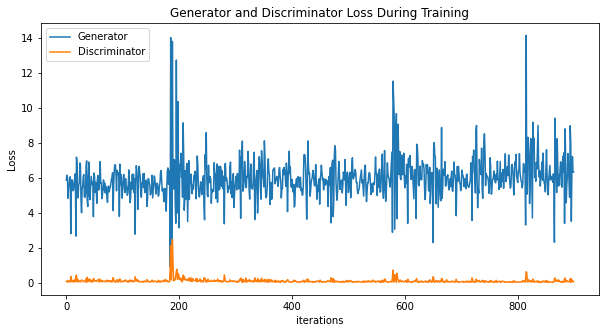

In [17]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_loss,label="Generator")
plt.plot(discriminator_loss,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# GIF visualization

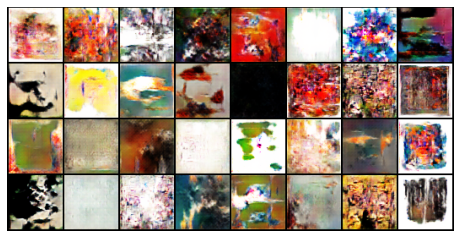

In [18]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=300, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# Save model

In [19]:
end_epoch = epoch_restore + epochs
save_file = "{}epochs.chkpt".format(end_epoch)

torch.save({
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'generator_optim_state_dict' : generator_optim.state_dict(),
            'discriminator_optim_state_dict' : discriminator_optim.state_dict(),}, save_file)